In [93]:
!pip install pystan==2.19.1.1
!pip install prophet


In [94]:
import pandas as pd
import numpy as np 
from prophet import Prophet

In [95]:
df = pd.read_csv('https://raw.githubusercontent.com/xxiang27/sikkaAIHackathon/main/data_file.csv')
df.head()

,id,month,year,visits,no_of_appts,production
0,34,3,2014,1,960,76.55
1,34,4,2014,488,1089,106333.80
2,34,5,2014,831,993,192230.40
3,34,6,2014,753,884,163515.12
4,34,7,2014,721,797,160185.90


First, we make datetime objects out of the dates. 

In [96]:
df['day'] = 1
dates = pd.to_datetime(df[['month', 'year','day']].copy())
dates.head()

0   2014-03-01
1   2014-04-01
2   2014-05-01
3   2014-06-01
4   2014-07-01
dtype: datetime64[ns]

In [97]:
df_final = pd.concat([dates, df],axis=1)
#df_final = df_final.drop(columns = ['month', 'year', 'day'])
df_final.columns.values[0] = 'date'
df_final.head()

,date,id,month,year,visits,no_of_appts,production,day
0,2014-03-01,34,3,2014,1,960,76.55,1
1,2014-04-01,34,4,2014,488,1089,106333.80,1
2,2014-05-01,34,5,2014,831,993,192230.40,1
3,2014-06-01,34,6,2014,753,884,163515.12,1
4,2014-07-01,34,7,2014,721,797,160185.90,1


We see in this correlation matrix that visits correlates most strongly with production, so we will use that as our extra regressor. 

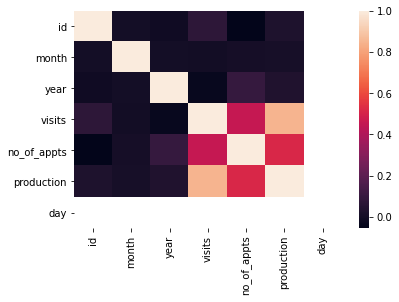

In [98]:
import seaborn as sns 
sns.heatmap(df_final.corr())

In [99]:
# separate dataframe into separate dataframes for each practice 

import math 
import copy

def separate(df):
  '''takes a dataframe return a list of dataframes mapped to id'''
  df_dict = {}
  grouped = df.groupby(df.id)
  for i in range(1, 285):
    df_dict[i] = grouped.get_group(i)
  return df_dict

def train_test_split(df_dict, add_test):
  '''takes a list of dataframes and returns the time series train and test split, based on how many days
  are to be in the test set'''
  test_set = {}
  for id, df in df_dict.items():
    df_add = df.tail(add_test).copy()
    test_set[id] = df_add
    df.drop(df.tail(add_test).index, inplace = True)
  return df_dict, test_set

def make_predictions_base(df_train, name, season_mode):
  '''model without regressors, used to predict visits'''
  make_predictions = {}
  for id,df in df_train.items():
    X = df[['date', name]]
    X.rename(columns={"date": "ds", name: "y"}, inplace = True)
    m = Prophet(weekly_seasonality=False, daily_seasonality = False, seasonality_mode = season_mode)
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    pred1 = forecast.tail(4)['yhat_upper'].to_numpy()
    pred2 = forecast.tail(4)['yhat_lower'].to_numpy()
    pred3 = forecast.tail(4)['trend'].to_numpy()
    pred4 = forecast.tail(4)['trend_lower'].to_numpy()
    pred5 = forecast.tail(4)['trend_upper'].to_numpy()
    make_predictions[id] = [pred,pred1,pred2,pred3,pred4,pred5]
  return make_predictions
    
def MAPE(y_true, y_pred):
	return np.mean(np.abs((y_true - y_pred)/y_true))*100

# need to make both of them dictionaries 
def score_more(predictions, actual, name):
  '''scores predictions for all clinics'''
  score_tot = []
  finals = []
  for j in range(6):
    scores = []
    cate = [0,0,0,0]
    for i in range(1, 285):
      score = MAPE(actual[i][name], predictions[i][j])
      scores.append(score)
      if score <= 5:
        cate[0] += 1
      elif score > 5 and score <=10:
        cate[1] += 1
      elif score >10 and score <= 15:
        cate[2] += 1
      else:
        cate[3] += 1
    total_score = (cate[0]/284 * 2) + (cate[1]/284 * 1) + (cate[2]/284 * -1) + (cate[3]/284 * -2)
    score_tot.append(copy.deepcopy(scores))
    finals.append(total_score)
  return score_tot, finals

def dentistry_season(ds):
  '''maps each month to their traffic level based on research into dentist traffic'''
  date = pd.to_datetime(ds)
  # high traffic
  if date.month in [11,12,1,2]:
    return 3 
  # med traffic
  if date.month in [8, 10,7, 4]:
    return 2
  # low traffic
  if date.month in [3,5,6,9]:
    return 1

def make_predictions_visit_regressor(df_train,season_mode, preds):
  '''prophet model with regressors'''
  make_predictions = {}
  for id,df in df_train.items():
    X = df[['date', 'visits', 'production']]
    X.rename(columns={"date": "ds", 'production': "y"}, inplace = True)
    m = Prophet(weekly_seasonality=False, daily_seasonality = False, seasonality_mode = season_mode)
    m.add_regressor('visits')
    m.fit(X)
    future = m.make_future_dataframe(periods = 4, freq = 'MS')
    future['visits'] = np.concatenate((df_train[id]['visits'].to_numpy(), preds[id][4]))
    forecast = m.predict(future)
    pred = forecast.tail(4)['yhat'].to_numpy()
    pred1 = forecast.tail(4)['yhat_upper'].to_numpy()
    pred2 = forecast.tail(4)['yhat_lower'].to_numpy()
    pred3 = forecast.tail(4)['trend'].to_numpy()
    pred4 = forecast.tail(4)['trend_lower'].to_numpy()
    pred5 = forecast.tail(4)['trend_upper'].to_numpy()
    make_predictions[id] = [pred,pred1,pred2,pred3,pred4,pred5]
  return make_predictions



We first use prophet to predict visits for our time frame, since visits need to be in the future dataframe to use as a regressor.

In [84]:
df_dict = separate(df_final)
train, test = train_test_split(df_dict, 4)
pred_visits = make_predictions_base(train, 'visits', 'multiplicative')


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 23.
/usr/local/lib/python3.7/dis

KeyboardInterrupt: ignored

We see how well we did with our visits predictions

In [ ]:
pred_score, pred_total = score_more(pred_visits, test)

In [ ]:
pred_total

Then we use the visits regressor to predict our production.

In [ ]:
%%capture
pred_prod = make_predictions_visit_regressor(train, 'multiplicative', pred_visits)

In [ ]:
score, total = score_more(pred_prod, test,'production')

In [ ]:
total

For our final product, we use the full data to make predictions

In [100]:
%%capture
pred_visits_final = make_predictions_base(df_dict, 'visits', 'multiplicative')
pred_prod_final = make_predictions_visit_regressor(df_dict, 'multiplicative', pred_visits_final)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoin

In [103]:
def make_final_df(preds):
  ids = []
  for i in range(1,285):
    ids += [i]*4
  months = [1,2,3,4]*284
  df = pd.DataFrame()
  df['id'] = ids
  df['month'] = months
  df['year'] = 2021
  prod = []
  for id, pred in preds.items():
    for j in range(len(pred[1])):
      prod.append(pred[1][j])
  df['production'] = prod
  return df 

In [104]:
results_df = make_final_df(pred_prod_final)
results_df.head()

,id,month,year,production
0,1,1,2021,40004.275472
1,1,2,2021,45944.535514
2,1,3,2021,48075.182886
3,1,4,2021,48831.537129
4,2,1,2021,63804.456272


In [105]:
results_df.to_csv('results.csv', index = False)